# Pythonを使って自然言語処理の前処理を行う

In [152]:
from pathlib import Path
import mojimoji
import neologdn
import unicodedata
import MeCab
import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [172]:
pd.set_option('max_columns', 1000)
pd.set_option('max_rows', 1000)

## パラメータの設定

In [30]:
data_dir_path = Path('data')
result_dir_path = Path('result')

if not result_dir_path.exists():
    result_dir_path.mkdir(parents=True)

## データの取得

In [4]:
#  「学問のすすめ」のデータを読み込む
with open(data_dir_path.joinpath('gakumonno_susume.txt'), 'r', encoding='utf-8') as file:
    lines = file.readlines()

### 指定した文を単語で分割

In [11]:
mecab = MeCab.Tagger('-Ochasen')

sentences = []
for sentence in lines:
    texts = sentence.split('。')
    sentences.extend(texts)

sentence = sentences[0]
words = mecab.parse(sentence)

print('元の文： ', sentence)
print('')
print('MeCabにより分割後')
print(words)

元の文：  「天は人の上に人を造らず人の下に人を造らず」と言えり

MeCabにより分割後
「	「	「	記号-括弧開		
天	テン	天	名詞-一般		
は	ハ	は	助詞-係助詞		
人	ヒト	人	名詞-一般		
の	ノ	の	助詞-連体化		
上	ウエ	上	名詞-非自立-副詞可能		
に	ニ	に	助詞-格助詞-一般		
人	ヒト	人	名詞-一般		
を	ヲ	を	助詞-格助詞-一般		
造ら	ツクラ	造る	動詞-自立	五段・ラ行	未然形
ず	ズ	ぬ	助動詞	特殊・ヌ	連用ニ接続
人	ヒト	人	名詞-一般		
の	ノ	の	助詞-連体化		
下	シタ	下	名詞-一般		
に	ニ	に	助詞-格助詞-一般		
人	ヒト	人	名詞-一般		
を	ヲ	を	助詞-格助詞-一般		
造ら	ツクラ	造る	動詞-自立	五段・ラ行	未然形
ず	ズ	ぬ	助動詞	特殊・ヌ	連用ニ接続
」	」	」	記号-括弧閉		
と	ト	と	助詞-格助詞-引用		
言え	イエ	言える	動詞-自立	一段	連用形
り	リ	り	助動詞	文語・リ	基本形
EOS



## 単語の出現回数を計測

In [27]:
mecab = MeCab.Tagger('-Owakati')
words = []
for sentence in sentences:
    words.extend(list(filter(
        lambda x: x != '',
        mecab.parse(sentence).replace('\n', '').split(' ')
    )))

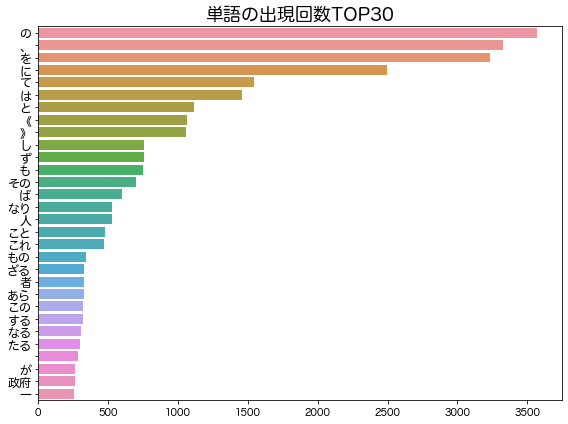

In [36]:
data = pd.DataFrame({'word': words}).assign(freq=1).groupby(
    'word'
)['freq'].count().reset_index().sort_values('freq', ascending=False)

top_n_word = 30
plt.figure(figsize=(8, 6))

sns.barplot(
    data=data.head(top_n_word),
    x='freq',
    y='word'
)
plt.title('単語の出現回数TOP{}'.format(top_n_word), fontsize=18)
plt.xlabel('')
plt.ylabel('')
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(result_dir_path.joinpath('word_count_top{}.png'.format(top_n_word)), dpi=300)

## ストップワードの削除と指定した品詞の抽出

In [38]:
#  ストップワードリストを取得する関数
def get_stopword_lsit(write_file_path):

    if not write_file_path.exists():
        url = 'http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt'
        urllib.request.urlretrieve(url, write_file_path)

    with open(write_file_path, 'r', encoding='utf-8') as file:
        stopword_list = [word.replace('\n', '') for word in file.readlines()]

    return stopword_list

In [41]:
stopword_list = get_stopword_lsit(
    data_dir_path.joinpath('stopword_list.txt')
)

In [45]:
stopword_list[:10]

['あそこ', 'あたり', 'あちら', 'あっち', 'あと', 'あな', 'あなた', 'あれ', 'いくつ', 'いつ']

### 名詞でストップワード以外の単語を抽出

In [137]:
def get_noun_words_from_sentence(sentence, mecab, stopword_list=[]):
    return [
        x.split('\t')[0] for x in mecab.parse(sentence).split('\n') if len(x.split('\t')) > 1 and \
         '名詞' in x.split('\t')[3] and x.split('\t')[0] not in stopword_list
    ]

In [46]:
mecab = MeCab.Tagger('-Ochasen')

sentence = sentences[0]

nouns = get_noun_words_from_sentence(
    sentence=sentence, mecab=mecab, stopword_list=stopword_list
)

In [64]:
print('元の文：')
print(sentence)
print('')
print('MeCabにより名詞抽出後:')
print(nouns)

元の文：
「天は人の上に人を造らず人の下に人を造らず」と言えり

MeCabにより名詞抽出後:
['天']


## 単語の正規化

### 表記ゆれの統一

In [94]:
s = "ｷﾀーーーーー━(・∀・)━!!!!ＤＱⅢ①⑳海海神神㌔㍉"
s = neologdn.normalize(s)
print(s)

キター(・∀・)ー!!!!DQⅢ①⑳海海神神㌔㍉


In [87]:
word1 = s[20]
word2 = s[21]
print('{} == {}'.format(word1, word2))
print('{}'.format(word1 == word2))

神 == 神
False


In [95]:
s = unicodedata.normalize("NFKC", s)
print(s)

キター(・∀・)ー!!!!DQIII120海海神神キロミリ


In [76]:
word1 = s[23]
word2 = s[24]
print('{} == {}'.format(word1, word2))
print('{}'.format(word1 == word2))

神 == 神
True


### 大文字を小文字に統一

In [96]:
s = 'iPhone'
s = s.lower()
print(s)

iphone


### 数字を０に統一

In [97]:
s = '円周率は3.14である'
s = re.sub(r'\d+\.*\d*', '0', s)
print(s)

円周率は0である


## 一連の前処理をして単語の出現回数を計測

In [155]:
def split_sentence(sentence, mecab, stopword_list):
    sentence = neologdn.normalize(sentence)
    sentence = unicodedata.normalize("NFKC", sentence)
    words = get_noun_words_from_sentence(
        sentence=sentence, mecab=mecab, stopword_list=stopword_list
    )
    words = list(map(lambda x: re.sub(r'\d+\.*\d*', '0', x.lower()), words))
    return words

mecab = MeCab.Tagger('-Ochasen')
words = []
for sentence in sentences:
    words.extend(split_sentence(sentence=sentence, mecab=mecab, stopword_list=stopword_list))

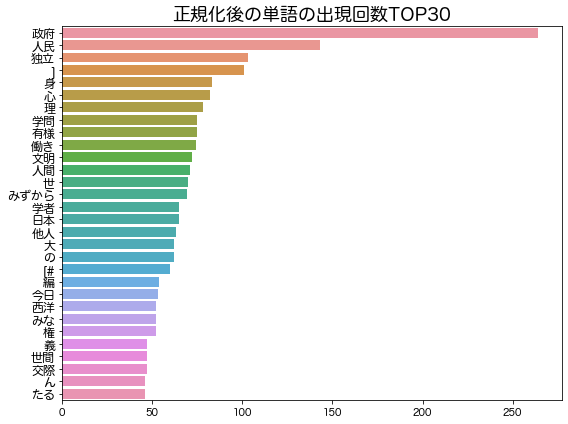

In [140]:
data = pd.DataFrame({'word': words}).assign(freq=1).groupby(
    'word'
)['freq'].count().reset_index().sort_values('freq', ascending=False)

top_n_word = 30
plt.figure(figsize=(8, 6))

sns.barplot(
    data=data.head(top_n_word),
    x='freq',
    y='word'
)
plt.title('正規化後の単語の出現回数TOP{}'.format(top_n_word), fontsize=18)
plt.xlabel('')
plt.ylabel('')
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(result_dir_path.joinpath('word_count_normalized_top{}.png'.format(top_n_word)), dpi=300)

## テキストを行列に変換する（Bag of Words）

In [158]:
mecab = MeCab.Tagger('-Ochasen')

words = []
for sentence in sentences:
    words.extend(split_sentence(sentence=sentence, mecab=mecab, stopword_list=stopword_list))

word_freq_pd = pd.DataFrame({'word': words}).assign(freq=1).groupby(
    'word'
)['freq'].count().reset_index().sort_values('freq', ascending=False)

word_freq_pd.head(10)

,word,freq
1937,政府,264
712,人民,143
2459,独立,103
5,],101
3203,身,83
1690,心,82
2477,理,78
1400,学問,75
2105,有様,75
836,働き,74


### 出現回数の分布

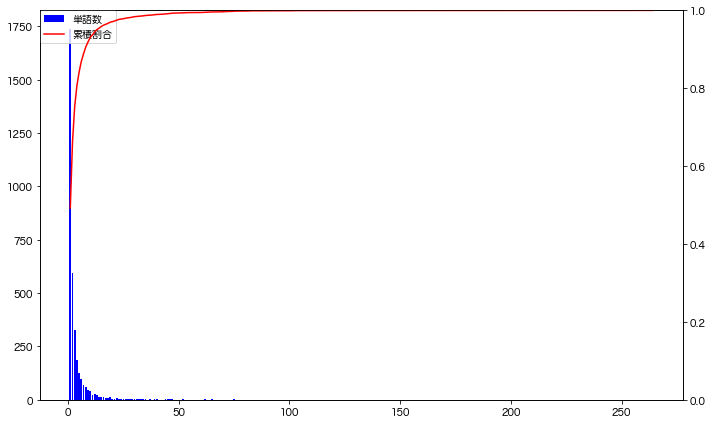

In [157]:
freq_pd = word_freq_pd.groupby('freq')['word'].count().reset_index().rename(
    columns={'word': 'n_word'}
).assign(total_n_word=lambda x: x.n_word.sum()).assign(
    rate=lambda x: x.n_word / x.total_n_word
).assign(cumsum=lambda x: x.rate.cumsum())

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

ax1.bar(freq_pd['freq'], freq_pd['n_word'], color='blue', label="単語数")
ax2.plot(freq_pd['freq'], freq_pd['cumsum'], color='red', label="累積割合")

handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
ax2.set_ylim(0, 1)

ax1.legend(handler1 + handler2, label1 + label2, loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig(result_dir_path.joinpath('word_count_cumsum.png'), dpi=300)

### テキストを数字列化

In [178]:
freq_lower = 3

bag_of_words = []
for i, sentence in enumerate(sentences):
    bag_of_words.extend([
        (i, word) for word in split_sentence(sentence=sentence, mecab=mecab, stopword_list=stopword_list)
    ])
    
bag_of_words = pd.DataFrame(bag_of_words, columns=['number', 'word'])
bag_of_words = pd.merge(
    bag_of_words,
    word_freq_pd.query('freq >= {}'.format(freq_lower))[['word']],
    on='word', how='inner'
).assign(freq=1).groupby(['number', 'word'])['freq'].count().reset_index().pivot_table(
    index='number',
    columns='word',
    fill_value=0
)
bag_of_words.columns = list(map(lambda x: x[1], bag_of_words.columns))
bag_of_words.to_csv(data_dir_path.joinpath('bag_of_words.csv'), index=False)
bag_of_words.head()

,0,[#,[#「,],|,、,〇,あん,い,いか,いかん,いくさ,いずれ,いち,いにしえ,いわく,うえ,お,おこし,おし,おの,お上,かい,かた,かたわら,かな,かん,きせん,きもの,きょう,きわ,きん,ぎ,くし,くじ,くも,ぐる,けい,げ,こ,ことわざ,この世,ご,さ,さかい,さき,さと,さま,ざる,しか,しき,しめ,じゅう,す,すすめ,すべ,ずし,ずる,せり,せん,そ,その間,たくま,ただ,たる,つま,つもり,つる,とく,としい,とも,ども,なす,なり,の,のみ,はか,はなし,ば,ばか,ひそか,ひとたび,ひとり,ひろ,び,びん,ふう,ふき,ふけ,ふさ,ふたつ,ほこ,ぼう,まつり,まれ,みずから,みな,む,むち,むね,むべ,むる,むることあらば,むるところなかるべからず,むるところにて,むるの,むるものは,め,めい,めし,めん,やす,ゅう,ゆ,ゆえ,ゆえん,ら,らん,わがまま,わが国,わが身,わが輩,わざ,わし,われ,わん,ん,アジヤ,アメリカ,インド,トルコ,フランス,ルーザ,ローマ,ヵ条,一事,一人前,一体,一命,一大,一家,一得,一掃,一揆,一方,一族,一時,一月,一朝,一段,一物,一種,一般,一身,万世,万国,万民,万物,三井,上下,上人,上流,上策,上野,下げ,下人,不,不便,不善,不孝,不実,不平,不幸,不徳,不正,不自由,不行届き,不足,不都合,世,世の中,世上,世人,世帯,世界,世界中,世話,世間,両,両様,並び,中津,主人,主客,主張,乞食,乱,乱暴,了簡,了解,争論,事務,事実,事情,事柄,事業,事物,事跡,二つ,云々,些末,亜,交わり,交易,交際,人々,人事,人前,人力,人口,人心,人情,人数,人智,人望,人民,人物,人生,人足,人身,人間,人類,仁政,今わ,今川,今年,今日,介,仏,仏法,仕事,仕入れ,仕方,仕立,他人,他国,付合い,代,以来,仮り,仲間,件,任,企,会社,位,住居,体裁,何事,余,使い,供給,依頼,便,便利,促,俗間,保護,俟,信,修,修業,修身,倍,倣,偏,健康,偶然,偽,傍,傍観,働き,儒者,優,優劣,元来,元金,兄弟,先生,先進,免,免状,入れ,入用,全体,全国,公,公事,公務,公方,公道,兵,兵備,具,内乱,内匠,内外,内証,冊,処,処置,出,出だし,出版,出願,分別,分限,刑,初,初学,利,利害,利益,制限,刺,前後,前条,前編,割合,力士,力量,功,功徳,功業,加,助言,勇,勉,勉強,勘定,務,務め,勝手次第,勢い,勤,勤め,勧,区別,医師,医者,十分,升,卑劣,卑屈,卑怯,博,却,厄介,厘毛,原因,原書,厭,厳,友,双方,反対,取り,取り計らい,取引,取扱い,取捨,取締り,受,古,古人,古今,古来,可,叶,同,同日,同様,同等,名代,名分,名目,名誉,君,君子,否,命,命令,和,和漢,咎,品物,品行,商,商人,商売,商社,善,善人,喧嘩,器械,国中,国人,国内,国土,国民,国法,土地,在,在官,地位,地理,地頭,域,堪忍,報国,場所,塞,塾,境界,士君子,士族,士農工商,売買,変人,変動,外国,外物,多少,夢,夢中,大,大人,大切,大名,大学,大家,大小,大工,大義,天,天下,天地,天性,天文,天然,天理,太平,太田,夫,夫婦,夫子,夷狄,奇,奇談,奔走,奢侈,女中,女子,奴隷,好,如何,妄想,妨,妨げ,妻子,妾,始末,姑,威,威光,婦人,嫁,嫉妬,子供,子孫,子弟,孔,孔子,存,孝行,孟子,孤立,学,学問,学校,学者,学術,孫,宅,安全,安心,安楽,安穏,宗教,官,...,新聞,新聞紙,方今,方便,方向,方正,日夜,日常,日新,日月,日本,日本人,日用,旦那,旧,旧友,旧習,旨,明,明らか,明日,明治,易,昔,昔日,昨日,是,時代,時勢,時日,時節,普請,普通,景気,智,智徳,智恵,智者,智識,暗殺,暴政,曲,書生,最初,月給,有力,有形,有志,有様,有用,朋友,朋輩,服,望み,朝寝,期限,本,本人,本国,本心,本意,束縛,条,条約,来,来年,東京,東西,枚挙,柄,柔順,栄誉,案外,棄,棚卸し,業,極,極度,概,標的,権,権助,権威,樹,機,機会,次第,欲,欺詐,歎息,正,正味,正直,武勇,歩,歳入,歴史,死,母,毒,毒害,比較,毫,氏,民,民間,気の毒,気力,気風,水晶,汗,沙汰,治,治乱,法律,注文,洋,洋学,活用,活発,活計,流,流儀,流行,浅野,浴,海,海陸,淫夫,深切,渡世,湯,満足,源,演説,災難,無,無力,無学,無形,無理,無用,無礼,無頼,父,父兄,父母,物,物事,犬,状,独立,珍,理,理学,理屈,理非,生,生々,生命,生徒,生涯,生計,産,田舎,由,由縁,申し分,申し訳,男女,男子,町人,異同,異説,疑い,病,痕跡,発明,発狂,百姓,百般,益,盗賊,盛ん,監察,目上,目的,相,相場,相対,相当,相応,相手,相談,相違,看板,真,真実,真率,真理,眼,着,石,石室,研究,社中,神,禁裏,禍,禽獣,私塾,私有,私立,科,科学,種,穴,窘,窮,窮理,窺,立身,端,端書,笞,筆,筋,答,策,箇条,算盤,節,節倹,範囲,米,米人,精密,精神,約定,約束,紙,細事,細君,経済,給,給料,維持,綿,緊要,総,編,縁,繁盛,罪,罪人,罰,羊,美,美事,美食,群居,義,義元,義務,義士,義気,習慣,老人,考,考え,耳,聖賢,職分,胆,背,能,腕,腰,腹,自,自国,自家,自由,自由自在,至,舟,船,良,良民,色,花,苛,若,苦,英,英国,英語,華族,著,著書,著述,蒔,蒸気,薄弱,薄情,藩,虚,虚名,虚飾,蚊,蟻,衆,行状,術,術策,衝,衣服,衣食,衣食住,表,表向き,被,裁,裁判,裁判所,裁決,西洋,要,覊,見出し,見識,見込み,規則,親,親子,親鸞,解,言,言葉,言行,言語,計,計り,討死,記,訳書,訴,訴訟,証拠,詐,評,評判,詞,試,試み,詳,誉,語,語学,誠,誠実,誤解,説,説諭,読書,誹謗,談,談話,論者,論語,論説,諫,諭,諭吉,諸,諸侯,諸国,諺,謀,謹慎,識,識者,譬,議論,議院,財,貧,貧乏,貧富,貧弱,貧窮,貫目,責,貯,貴,貴人,資,賊,賜,賢良,賤,赤穂,起居,趣,趣向,趣意,趣旨,足,足軽,跡,路,身,身代,身体,身分,身心,車,軒,軽,軽蔑,軽重,輩,農,迂遠,近日,近来,述,通義,逞,造化,進歩,遁,遊冶,運,運上,過,過分,遑,道具,道徳,道理,違約,遺物,避,邏卒,酒,酒色,里,重き,野蛮,鉄橋,鉄道,銘々,銭,鋒,鎖国,長,長物,長短,開化,開闢,間柄,間違い,限り,際限,隣,隣家,離,難,難易,電信,静か,非,靡,面目,領分,頭,頼み,額,顔色,顕,願い,顰,風,風俗,食,食客,食物,飯,飲酒,飲食,首唱,馬鹿,駿河,高尚,高遠,鬼,魂,麦,齟齬
number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [177]:
matrixes = bag_of_words.values
np.save(data_dir_path.joinpath('bag_of_words.npy'), matrixes)